In [1]:
%%capture --no-stderr
%uv add ipykernel langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [1]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [6]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto=agent_name,  
            update={**state, "messages": state["messages"] + [tool_message]},  
            graph=Command.PARENT,  
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

In [7]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

In [9]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [10]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

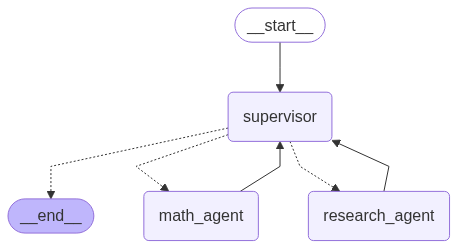

In [11]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [12]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

- US GDP in 2024: $28.7 trillion (nominal, see Wikipedia source: [List of U.S. states and territories by GDP](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP))
- New York State GDP in 2024: $2.297 trillion (nominal, see Wikipedia source: [Economy of New York (state)](https://en.wikipedia.org/wiki/Economy_of_New_York_(state)))
- New York's share of US GDP in 2024: approximately 8%


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================== Ai Message =

In [13]:
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}
        return Command(
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_research_agent_with_description = create_task_description_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent_with_description = create_task_description_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this assistant\n"
        "- a math agent. Assign math-related tasks to this assistant\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, destinations=("research_agent", "math_agent")
    )
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

In [14]:
for chunk in supervisor_with_description.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_research_agent (call_UrQRhIjRj39DSLWsWGRBzVIB)
	 Call ID: call_UrQRhIjRj39DSLWsWGRBzVIB
	  Args:
	    task_description: Find the most recent available 2024 GDP data for the United States and for New York State. Provide the sources or estimates for both figures.


Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  tavily_search (call_unK37RLNkMtmW3IzSNWSiQnt)
	 Call ID: call_unK37RLNkMtmW3IzSNWSiQnt
	  Args:
	    query: most recent 2024 GDP data for the United States
	    search_depth: advanced
	  tavily_search (call_NtUYIEICx4NBR7wBx5wOXsEl)
	 Call ID: call_NtUYIEICx4NBR7wBx5wOXsEl
	  Args:
	    query: most recent 2024 GDP data for New York State
	    search_depth: a